# 281 BRISK Keypoints and Description

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import urllib
import os
import cv2


import skimage
from skimage.exposure import rescale_intensity
from skimage.transform import rescale, rotate
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import cosine
from skimage.feature import graycomatrix, graycoprops
from skimage import io

from sklearn.manifold import TSNE

In [3]:
test_path = './seg_test/seg_test/'
train_path = './seg_train/seg_train/'

In [4]:
# read image with histogram equalization
def read_image(in_path):
    # Check if the file path ends with ".jpg"
    if in_path.lower().endswith('.jpg'):
        #read as grey scale
        img = cv2.imread(in_path, 0)

        # Histogram equalization
        img = np.uint8(cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX))
        img = cv2.equalizeHist(img)

        # Convert to floating-point image with intensity [0, 1]
        if np.max(img) > 1:
            img = img.astype(np.float32) / 255.0
        
        # Rescale
        standard = 150
        scale = standard / min(img.shape[:2])
        img = rescale(img, scale, anti_aliasing=False)
        img = img[int(img.shape[0]/2 - standard/2) : int(img.shape[0]/2 + standard/2),
                  int(img.shape[1]/2 - standard/2) : int(img.shape[1]/2 + standard/2)]

        #Convert to ubyte for many of the features
    img = skimage.img_as_ubyte(img)

    return img

In [5]:
df_train = pd.read_csv('train_data.csv', index_col=0)
df_val = pd.read_csv('val_data.csv', index_col=0)
df_test = pd.read_csv('test_data.csv', index_col=0)

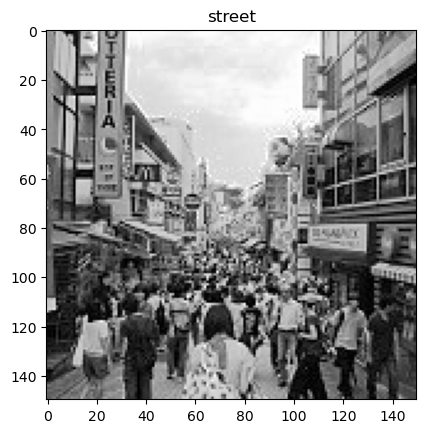

(150, 150)

In [6]:
# Load the image from a file
img = read_image(df_train['files'][11000])
# Get the label for the image
label = df_train['labels'][11000]
# Display the image
plt.imshow(img, cmap='gray')  # 'cmap' specifies the colormap for grayscale
plt.title(label)  # Set the title to the label
plt.show()

img.shape

In [7]:
des_list = []

brisk = cv2.BRISK_create(30)
brisk

< cv2.BRISK 0x107e07330>

In [8]:
des_lst = []
kpts_lst = []

for file in df_train['files']:
    img = read_image(file)
    (kpts, des) = brisk.detectAndCompute(img, None)
    des_lst.append((file, des))
    kpts_lst.append((file, kpts))

In [9]:
len(des_lst)

11230

In [51]:
# img without keypoints
#des_lst[6335]
# df_train[df_train['files']=='./seg_train/seg_train/mountain/14283.jpg']

,files,labels,train_or_val
6335,./seg_train/seg_train/mountain/14283.jpg,mountain,training


In [10]:
descriptors = des_lst[0][1]
image_paths = []
none_images=[]
for image_path, descriptor in des_lst[1:]:
    if descriptor is not None:
        descriptors = np.vstack((descriptors, descriptor))
        image_paths.append(image_path)
    else:
        none_images.append(image_path)

In [11]:
none_images

[]

In [12]:
descriptors.shape

(6557718, 64)

In [13]:
from scipy.cluster.vq import kmeans, vq

descriptors_float = descriptors.astype(float)

k = 100
voc, variance = kmeans(descriptors_float, k, 1)

In [14]:
im_features = np.zeros((len(df_train['files']), k), "float32")
for i in range(len(df_train['files'])):
    words, distance = vq(des_lst[i][1], voc)
    for w in words: 
        im_features[i][w] +=1

In [16]:
# Create a DataFrame with column names 1 through 200
column_names = [str(i) for i in range(1, 101)]
df_bow = pd.DataFrame(im_features, columns=column_names)

In [17]:
df_bow

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,15.0,5.0,12.0,2.0,7.0,0.0,4.0,6.0,0.0,3.0,...,3.0,2.0,3.0,3.0,3.0,3.0,2.0,1.0,3.0,8.0
1,11.0,5.0,5.0,2.0,3.0,6.0,10.0,3.0,7.0,3.0,...,3.0,12.0,19.0,2.0,13.0,5.0,1.0,1.0,1.0,2.0
2,0.0,0.0,1.0,2.0,9.0,5.0,2.0,2.0,2.0,5.0,...,2.0,1.0,3.0,2.0,1.0,4.0,5.0,0.0,1.0,2.0
3,7.0,5.0,9.0,1.0,2.0,2.0,5.0,4.0,6.0,2.0,...,1.0,6.0,5.0,2.0,0.0,4.0,4.0,0.0,3.0,3.0
4,3.0,8.0,8.0,3.0,6.0,5.0,9.0,6.0,7.0,4.0,...,5.0,8.0,6.0,8.0,6.0,6.0,7.0,3.0,9.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11225,3.0,6.0,4.0,6.0,8.0,0.0,9.0,12.0,3.0,2.0,...,4.0,3.0,6.0,10.0,3.0,4.0,7.0,4.0,7.0,3.0
11226,3.0,7.0,1.0,8.0,2.0,8.0,0.0,6.0,8.0,2.0,...,1.0,0.0,4.0,3.0,2.0,4.0,2.0,6.0,4.0,5.0
11227,5.0,5.0,4.0,6.0,13.0,10.0,7.0,10.0,4.0,9.0,...,4.0,3.0,5.0,8.0,6.0,7.0,5.0,10.0,4.0,7.0
11228,4.0,0.0,6.0,9.0,7.0,9.0,5.0,7.0,9.0,7.0,...,5.0,8.0,8.0,11.0,4.0,3.0,9.0,11.0,4.0,1.0


In [18]:
result_df = pd.concat([df_train, df_bow], axis=1)

In [19]:
result_df

,files,labels,train_or_val,1,2,3,4,5,6,7,...,91,92,93,94,95,96,97,98,99,100
0,./seg_train/seg_train/buildings/0.jpg,building,training,15.0,5.0,12.0,2.0,7.0,0.0,4.0,...,3.0,2.0,3.0,3.0,3.0,3.0,2.0,1.0,3.0,8.0
1,./seg_train/seg_train/buildings/1001.jpg,building,training,11.0,5.0,5.0,2.0,3.0,6.0,10.0,...,3.0,12.0,19.0,2.0,13.0,5.0,1.0,1.0,1.0,2.0
2,./seg_train/seg_train/buildings/10014.jpg,building,training,0.0,0.0,1.0,2.0,9.0,5.0,2.0,...,2.0,1.0,3.0,2.0,1.0,4.0,5.0,0.0,1.0,2.0
3,./seg_train/seg_train/buildings/10018.jpg,building,training,7.0,5.0,9.0,1.0,2.0,2.0,5.0,...,1.0,6.0,5.0,2.0,0.0,4.0,4.0,0.0,3.0,3.0
4,./seg_train/seg_train/buildings/10056.jpg,building,training,3.0,8.0,8.0,3.0,6.0,5.0,9.0,...,5.0,8.0,6.0,8.0,6.0,6.0,7.0,3.0,9.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11225,./seg_train/seg_train/street/9961.jpg,street,training,3.0,6.0,4.0,6.0,8.0,0.0,9.0,...,4.0,3.0,6.0,10.0,3.0,4.0,7.0,4.0,7.0,3.0
11226,./seg_train/seg_train/street/9967.jpg,street,training,3.0,7.0,1.0,8.0,2.0,8.0,0.0,...,1.0,0.0,4.0,3.0,2.0,4.0,2.0,6.0,4.0,5.0
11227,./seg_train/seg_train/street/9978.jpg,street,training,5.0,5.0,4.0,6.0,13.0,10.0,7.0,...,4.0,3.0,5.0,8.0,6.0,7.0,5.0,10.0,4.0,7.0
11228,./seg_train/seg_train/street/9989.jpg,street,training,4.0,0.0,6.0,9.0,7.0,9.0,5.0,...,5.0,8.0,8.0,11.0,4.0,3.0,9.0,11.0,4.0,1.0


/Users/amandamurray/anaconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/amandamurray/anaconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/amandamurray/anaconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/amandamurray/anaconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

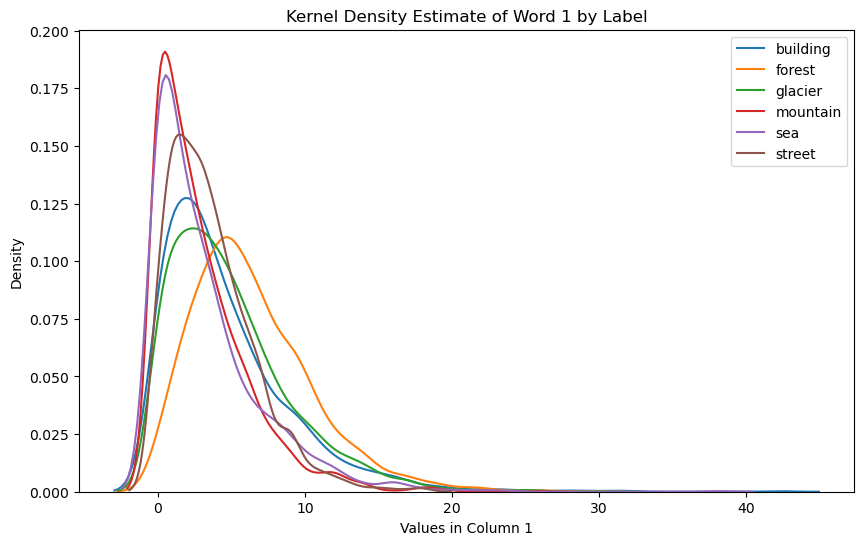

In [20]:
import seaborn as sns
# Replace '1' with the actual column name you want to plot
column_name = '1'

# Group the DataFrame by the 'labels' column
grouped_df = result_df.groupby('labels')

# Plot a kernel density estimate for each label
plt.figure(figsize=(10, 6))

for label, group in grouped_df:
    sns.kdeplot(group[column_name], label=label)

plt.xlabel(f'Values in Column {column_name}')
plt.ylabel('Density')
plt.title(f'Kernel Density Estimate of Word {column_name} by Label')
plt.legend()
plt.show()

In [123]:
# result_df.columns.to_list()

In [22]:
X = result_df[[str(i) for i in range(1, 101)]]
y = result_df['labels']

In [23]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)
tsne_df = pd.DataFrame(data=X_tsne, columns=['Dimension 1', 'Dimension 2'])
tsne_df['Labels'] = y

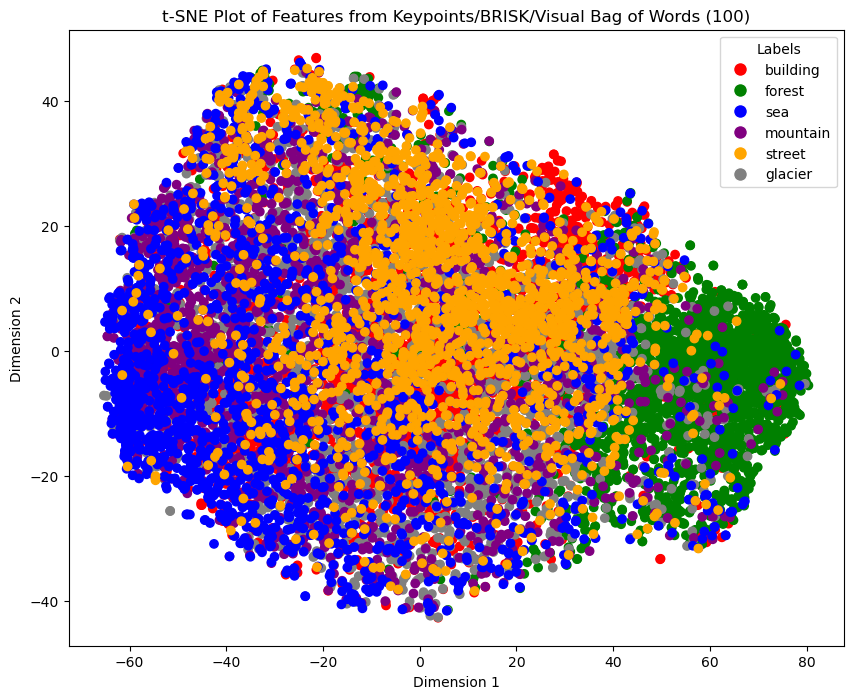

In [25]:
# Define custom colors for each label
label_colors = {'building': 'red', 'forest': 'green', 'sea': 'blue', 'mountain': 'purple', 'street': 'orange', 'glacier': 'grey'}

# Plot the results
plt.figure(figsize=(10, 8))

# Scatter plot with custom colors
scatter = plt.scatter(tsne_df['Dimension 1'], tsne_df['Dimension 2'], c=tsne_df['Labels'].map(label_colors))

# Add a legend with custom colors
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_colors[label], markersize=10, label=label) for label in label_colors]
plt.legend(handles=legend_labels, title='Labels')

plt.title('t-SNE Plot of Features from Keypoints/BRISK/Visual Bag of Words (100)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

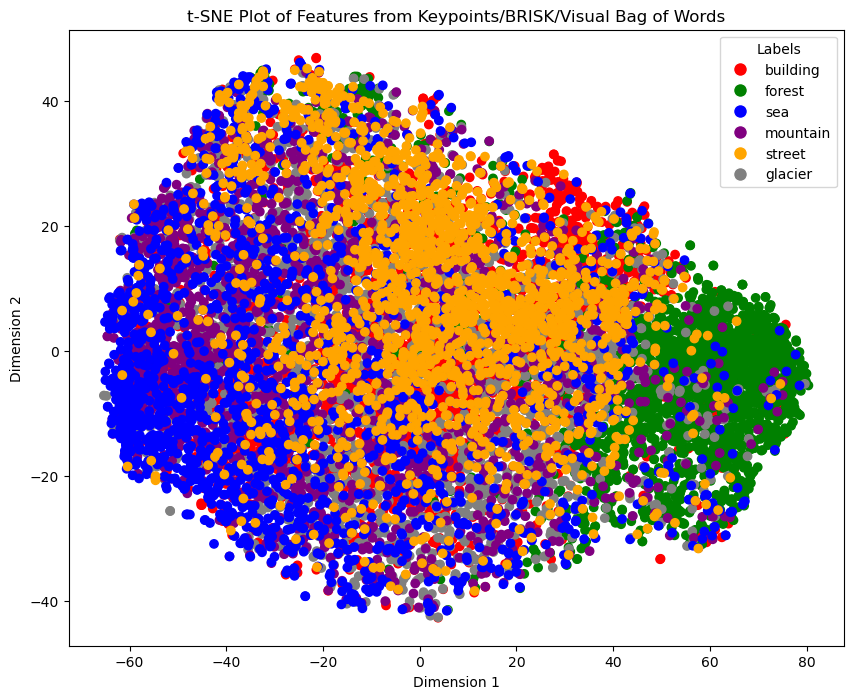

In [24]:
# Define custom colors for each label
label_colors = {'building': 'red', 'forest': 'green', 'sea': 'blue', 'mountain': 'purple', 'street': 'orange', 'glacier': 'grey'}

# Plot the results
plt.figure(figsize=(10, 8))

# Scatter plot with custom colors
scatter = plt.scatter(tsne_df['Dimension 1'], tsne_df['Dimension 2'], c=tsne_df['Labels'].map(label_colors))

# Add a legend with custom colors
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_colors[label], markersize=10, label=label) for label in label_colors]
plt.legend(handles=legend_labels, title='Labels')

plt.title('t-SNE Plot of Features from Keypoints/BRISK/Visual Bag of Words')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

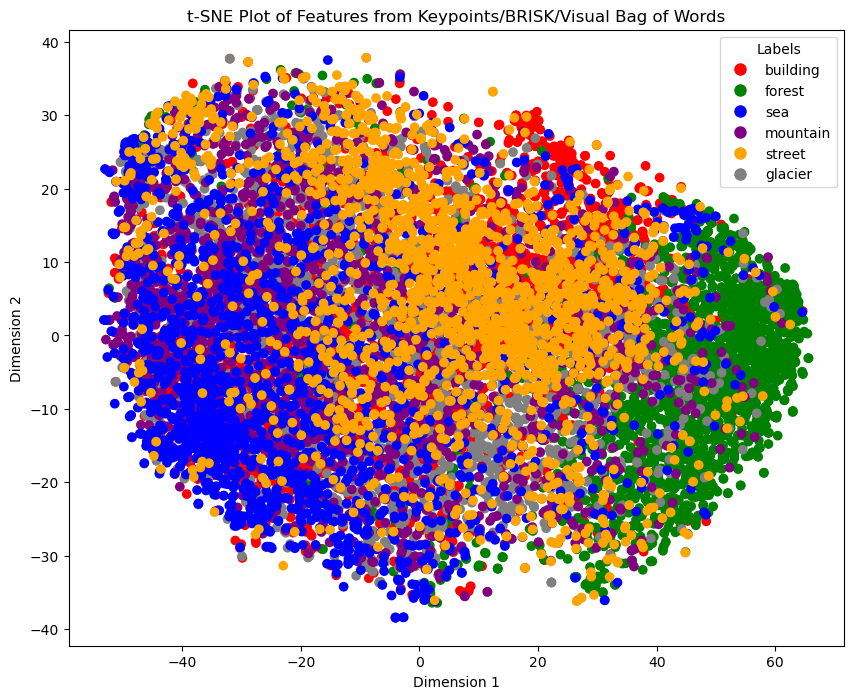

In [133]:
# Define custom colors for each label
label_colors = {'building': 'red', 'forest': 'green', 'sea': 'blue', 'mountain': 'purple', 'street': 'orange', 'glacier': 'grey'}

# Plot the results
plt.figure(figsize=(10, 8))

# Scatter plot with custom colors
scatter = plt.scatter(tsne_df['Dimension 1'], tsne_df['Dimension 2'], c=tsne_df['Labels'].map(label_colors))

# Add a legend with custom colors
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_colors[label], markersize=10, label=label) for label in label_colors]
plt.legend(handles=legend_labels, title='Labels')

plt.title('t-SNE Plot of Features from Keypoints/BRISK/Visual Bag of Words')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [ ]:
img = read_image(df_train['files'][0])
(kpts, des) = brisk.detectAndCompute(img, None)
img2 = cv2.drawKeypoints(img, kpts, None, flags=0)
cv2.imshow('Corners',img2)
cv2.waitKey(0)